In [2]:
%load_ext autoreload
%autoreload 2

import os
import re
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
%matplotlib ipympl

from typing import Tuple, Union, Callable, List


In [3]:
data_path = os.path.abspath('../donnees/vents')
imp_path = os.path.join(data_path, 'impedance')
mouth_path = os.path.join(data_path, 'bouche_flute')
mouth_mes_path = os.path.join(mouth_path, 'mesures')

## Mesures et diagrammes de bifurcation

In [4]:
mouth_data_pat = re.compile(r'\w+\.csv')

mouth_mes_files = [(os.path.splitext(x)[0], os.path.join(mouth_mes_path, x)) for x in os.listdir(mouth_mes_path) if mouth_data_pat.match(x)]
mouth_mes = dict([(mes_file[0], np.loadtxt(mes_file[1], skiprows=1, delimiter=',')) for mes_file in mouth_mes_files])
# columns: input pressure | output freq | output tension

mouth_ext = np.loadtxt(os.path.join(mouth_path, 'ext.csv'), skiprows=1, delimiter=',')
print(mouth_ext)

[[ 1. 48.]
 [ 0. 43.]
 [ 1. 35.]
 [ 0. 25.]]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
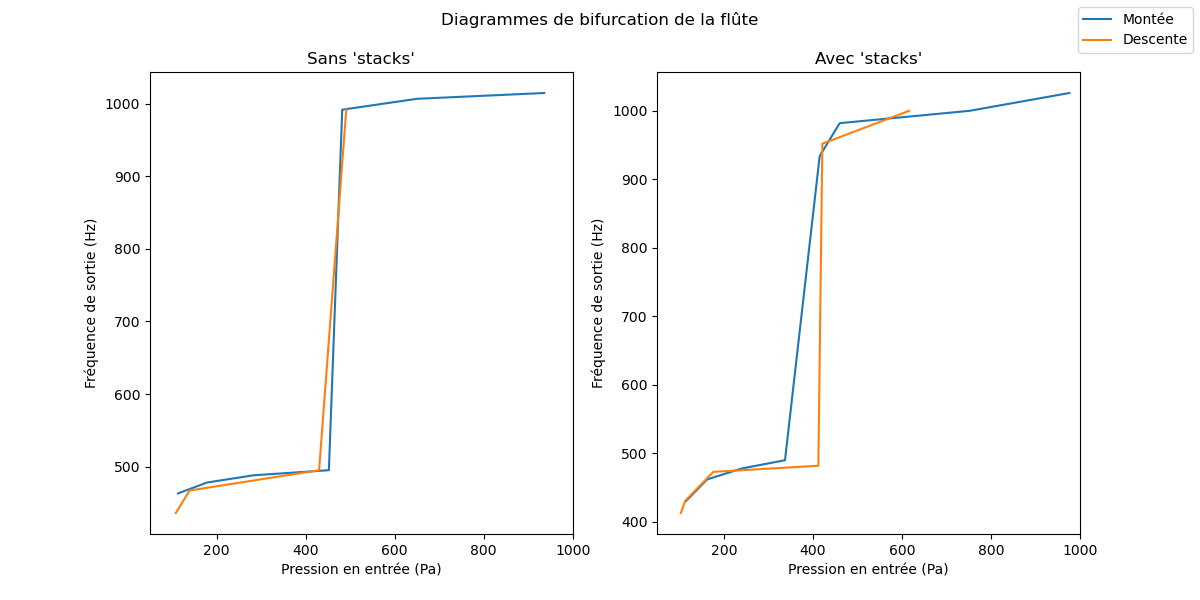

In [5]:
d_sm = mouth_mes['sm']
d_sd = mouth_mes['sd']
d_nm = mouth_mes['nm']
d_nd = mouth_mes['nd']
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Diagrammes de bifurcation de la flûte")
plot_nm, = axes[0].plot(d_nm[:, 0], d_nm[:, 1])
plot_nd, = axes[0].plot(d_nd[:, 0], d_nd[:, 1])
plot_sm, = axes[1].plot(d_sm[:, 0], d_sm[:, 1])
plot_sd, = axes[1].plot(d_sd[:, 0], d_sd[:, 1])
#
axes[0].set_title("Sans 'stacks'")
axes[1].set_title("Avec 'stacks'")
axes[0].set_xlabel("Pression en entrée (Pa)")
axes[0].set_ylabel("Fréquence de sortie (Hz)")
axes[0].set_xlim(50, 1000)
axes[1].set_xlabel("Pression en entrée (Pa)")
axes[1].set_ylabel("Fréquence de sortie (Hz)")
axes[1].set_xlim(50, 1000)
#
fig.legend([plot_nm, plot_nd], ['Montée', 'Descente'])
#
plt.show()

## Mesures d'impédance

In [45]:
imp_data_pat = re.compile(r'(?P<it>\d+)_(?P<cond>\w+).csv')

def get_imp_measure_info(pat: re.Pattern, f: str):
    m_path = re.match(pat, f)
    if m_path is None:
        raise AttributeError(f"Pattern {pat} not found in {f}.")
    g_path = m_path.groupdict()
    return g_path

imp_mes = dict()
for f in os.listdir(imp_path):
    path = os.path.join(imp_path, f)
    info = get_imp_measure_info(imp_data_pat, f)
    if not info['cond'] in imp_mes:
        imp_mes[info['cond']] = [None] * 2
    imp_mes[info['cond']][int(info['it'])-1] = np.loadtxt(path, skiprows=1, delimiter=',')
for mes in imp_mes:
    imp_mes[mes] = np.array(imp_mes[mes])


Q mesuré des trois premiers modes):
Sans stacks: Q=[89.2, 99.66666666666667, 107.96]
Avec stacks: Q=[15.571428571428571, 19.444444444444443, 35.23684210526316]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
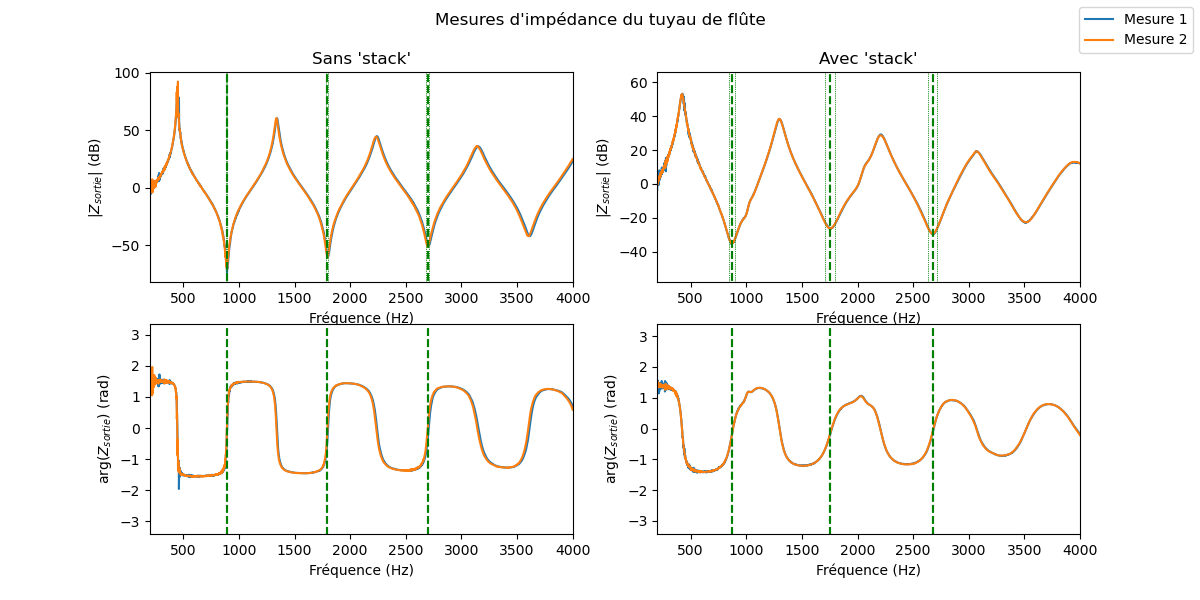

In [68]:
def plot_imp_measure(d: np.ndarray, fs: List, axes, idx: int, title: str, x_lim: Tuple[float, float], x_label: str, y_label: str):
    f = d[:, 0]
    z = d[:,1] + 1j*d[:,2]
    z_mod_db = 20 * np.log(np.abs(z))
    # z_mod_db = np.abs(z)
    z_phase = np.angle(z)
    plot, = axes[0][idx].plot(f, z_mod_db)
    axes[1][idx].plot(f, z_phase)
    axes[0][idx].set_title(title)
    axes[0][idx].set_xlabel(x_label)
    axes[0][idx].set_ylabel(f"|{y_label}| (dB)")
    axes[0][idx].set_xlim(x_lim)
    # axes[1][idx].set_title(title)
    axes[1][idx].set_xlabel(x_label)
    axes[1][idx].set_ylabel(f"arg({y_label}) (rad)")
    axes[1][idx].set_xlim(x_lim)
    for f in fs:
        # f_is
        l1 = axes[0][idx].axvline(x=f[0], ymin=-180, ymax=50)
        l2 = axes[1][idx].axvline(x=f[0], ymin=-180, ymax=50)
        l1.set_color('green')
        l2.set_color('green')
        l1.set_linestyle('--')
        l2.set_linestyle('--')
        #
        l11 = axes[0][idx].axvline(x=f[1], ymin=-180, ymax=50)
        l12 = axes[0][idx].axvline(x=f[2], ymin=-180, ymax=50)
        l11.set_color('green')
        l12.set_color('green')
        l11.set_linestyle(':')
        l12.set_linestyle(':')
        l11.set_linewidth(0.5)
        l12.set_linewidth(0.5)
    return plot

d_imp_n = imp_mes['n'] # no stack
d_imp_s = imp_mes['s'] # stack
#
compute_q = lambda f_0, f_m, f_p : (f_0) / ((f_p - f_m))
# Pics des minima trouvés à la main
# les minima (f_0, f_1, f_2)
imp_n_fs = [(892, 885, 895), (1794, 1786, 1804), (2699, 2684, 2709)]
imp_n_qs = [compute_q(f[0], f[1], f[2]) for f in imp_n_fs]
#
imp_s_fs = [(872, 845, 901), (1750, 1712, 1802), (2678, 2638, 2714)]
imp_s_qs = [compute_q(f[0], f[1], f[2]) for f in imp_s_fs]
#
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
fig.suptitle("Mesures d'impédance du tuyau de flûte")

plot_1 = plot_imp_measure(d_imp_n[0], imp_n_fs, axes, 0, "Sans 'stack'", (200, 4000), 'Fréquence (Hz)', '$Z_{sortie}$')
plot_imp_measure(d_imp_s[0], imp_s_fs, axes, 1, "Avec 'stack'", (200, 4000), 'Fréquence (Hz)', '$Z_{sortie}$')
plot_2 = plot_imp_measure(d_imp_n[1], imp_n_fs, axes, 0, "Sans 'stack'", (200, 4000), 'Fréquence (Hz)', '$Z_{sortie}$')
plot_imp_measure(d_imp_s[1], imp_s_fs, axes, 1, "Avec 'stack'", (200, 4000), 'Fréquence (Hz)', '$Z_{sortie}$')

fig.legend([plot_1, plot_2], ['Mesure 1', 'Mesure 2'])
#
print("Q mesuré des trois premiers modes):")
print(f"Sans stacks: Q={imp_n_qs}")
print(f"Avec stacks: Q={imp_s_qs}")
#
plt.show()